# `Perspective-n-Points` algorithm

In [2]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass, set_env_joint_configuration, get_env_joint_names, print_env_joint_infos, get_env_obj_names, set_env_obj, get_env_obj_poses
from util import rpy2r,pr2t,t2pr
from util_fk import *
import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


### Parse `UR5e`

In [3]:
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


### Get camera informations

In [4]:
cam_infos = env.set_cam_infos(cam_distance  = 0.5,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.2,0.0,1.5])
cam_infos

{'cam_distance': 0.5,
 'cam_azimuth': 0.0,
 'cam_elevation': -90.0,
 'cam_lookat': array([1.2, 0. , 1.5])}

[0/7] obj_name:[obj_cylinder_1]
[1/7] obj_name:[obj_cylinder_2]
[2/7] obj_name:[obj_cylinder_3]
[3/7] obj_name:[obj_cylinder_1_thick]
[4/7] obj_name:[obj_cylinder_2_thick]
[5/7] obj_name:[obj_cylinder_3_thick]
[6/7] obj_name:[obj_box_1]


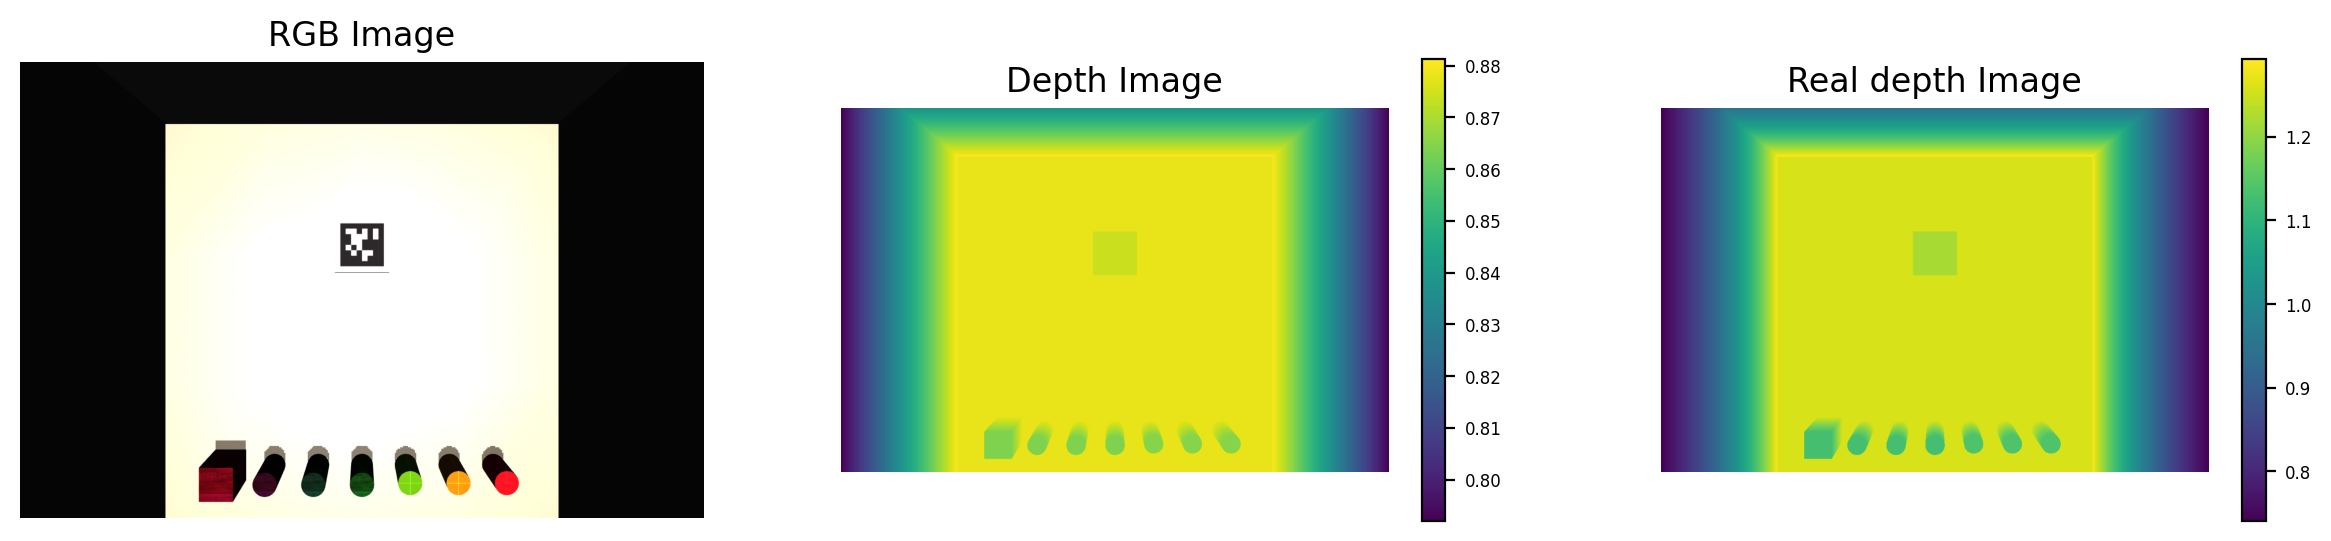

In [5]:
import math

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2

# Check available objects whose names start with 'obj_'
obj_names = get_env_obj_names(env,prefix='obj_') # see objects
for obj_idx,obj_name in enumerate(obj_names):
    print ("[%d/%d] obj_name:[%s]"%(obj_idx,len(obj_names),obj_name))

# Initialize position
colors = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,len(obj_names))]
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [0.8,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    obj_color = colors[obj_idx]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=obj_color)

# Set Joint Configurations
init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2 ]
set_env_joint_configuration(env, init_configurations, prefix='ur_')

# update object locations
env.forward(INCREASE_TICK=False)

width = 1500
height = 1000
ur_joint_idx = np.array([0, 1, 2, 3, 4, 5, 6], dtype=np.int32)

# env.sim.data.qpos[:8] = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2, 0, 0] 
# torque = [-math.pi/2, -6*math.pi/8, 2*math.pi/3, math.pi/2, math.pi/4, 0, False] 
# env.step(ctrl=torque, ctrl_idxs=ur_joint_idx)

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=True, camera_name="track")
    img_real = np.array(env.depth2meters(img_depth))

plt.figure(figsize=(15,3))
plt.subplot(1, 3, 1)
plt.imshow(img); plt.axis('off')
plt.title("RGB Image")
# plt.show()

plt.subplot(1, 3, 2)
plt.imshow(img_depth); plt.axis('off')
plt.title("Depth Image")
plt.colorbar()
# plt.show()

plt.subplot(1, 3, 3)
plt.imshow(img_real); plt.axis('off')
plt.title("Real depth Image")
plt.colorbar()
plt.show()

### Get `AprilTag` Informations

##### Draw Bounding-Box

In [6]:
def draw_bbox(results, image, verbose=False):
    width = 1500
    height = 1000

    for r in results:
        # extract the bounding box (x, y)-coordinates for the AprilTag
        # and convert each of the (x, y)-coordinate pairs to integers
        (ptA, ptB, ptC, ptD) = r.corners
        ptB = (int(ptB[0]), int(ptB[1]))
        ptC = (int(ptC[0]), int(ptC[1]))
        ptD = (int(ptD[0]), int(ptD[1]))
        ptA = (int(ptA[0]), int(ptA[1]))

        # draw the bounding box of the AprilTag detection
        cv2.line(image, ptA, ptB, (255, 0, 0), 3)
        cv2.line(image, ptB, ptC, (255, 0, 0), 3)
        cv2.line(image, ptC, ptD, (255, 0, 0), 3)
        cv2.line(image, ptD, ptA, (255, 0, 0), 3)

        # draw the center (x, y)-coordinates of the AprilTag
        (cX, cY) = (int(r.center[0]), int(r.center[1]))
        cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)

        # draw the tag family on the image
        tagFamily = r.tag_family.decode("utf-8")
    
        if verbose == True:
            cv2.putText(image, tagFamily, (ptA[0], ptA[1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 5.0, (255, 255, 255), 3)
            # print("Apriltag name: {}".format(tagFamily))

            x_centered = cX - width / 2
            y_centered = -1 * (cY - height / 2)

            cv2.putText(image, f"Center X coord: {x_centered}", (ptB[0] + 10, ptB[1] - 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.5, (125, 0, 125), 7)

            cv2.putText(image, f"Center Y coord: {y_centered}", (ptB[0] + 10, ptB[1]),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (125, 0, 125), 7)

            cv2.putText(image, f"Tag ID: {r.tag_id}", (ptC[0] - 70, ptC[1] - 15),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (125, 0, 125), 7)

        cv2.circle(image, (int((width / 2)), int((height / 2))), 5, (0, 0, 255), 2)

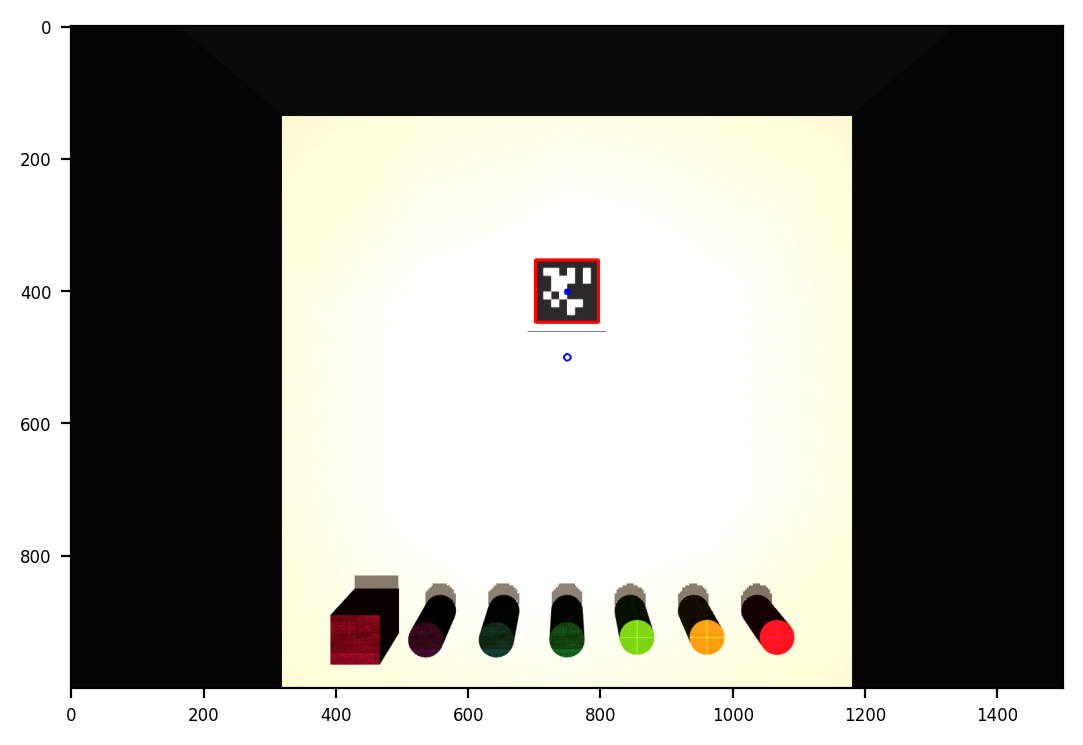

In [7]:
import apriltag

# Set AprilTag configurations
april_addr_z = env.sim.model.get_joint_qpos_addr('box_checker_z')
env.sim.data.qpos[april_addr_z] = -math.pi/2 # + math.pi/2

# update object locations
env.forward(INCREASE_TICK=False)

width = 1500
height = 1000

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=True, camera_name="track")
    img_real = np.array(env.depth2meters(img_depth))

detector = apriltag.Detector()
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

# detections, dimg = detector.detect(fram_gray, return_image=True)
results = detector.detect(img_Gray)

cam_matrix, _, _ = env.camera_matrix_and_pose(width=env.render_width, height=env.render_height, camera_name="main1")
# cam_matrix, _, _ = env.camera_matrix_and_pose(width=env.render_height, height=env.render_width, camera_name="main1")

fx = cam_matrix[0][0]
cx = cam_matrix[0][2]
fy = cam_matrix[1][1]
cy = cam_matrix[1][2]

cam_params = [fx, fy, cx, cy]

# Render the detections on the image
if len(results) > 0:
    draw_bbox(results, img, verbose=False)

    for r in results:
        pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.06)    # should check tag_size
        
        poseRotation = pose[:3, :3]
        poseTranslation = pose[:3, 3]

    plt.imshow(img) # ; plt.axis('off')
    plt.show()

##### Pose information using AprilTag.detection_pose()

[[ 1.00e+00  1.38e-03 -7.54e-03  2.52e-04]
 [-7.47e-04  9.97e-01  8.27e-02 -6.26e-02]
 [ 7.63e-03 -8.27e-02  9.97e-01  7.62e-01]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]]


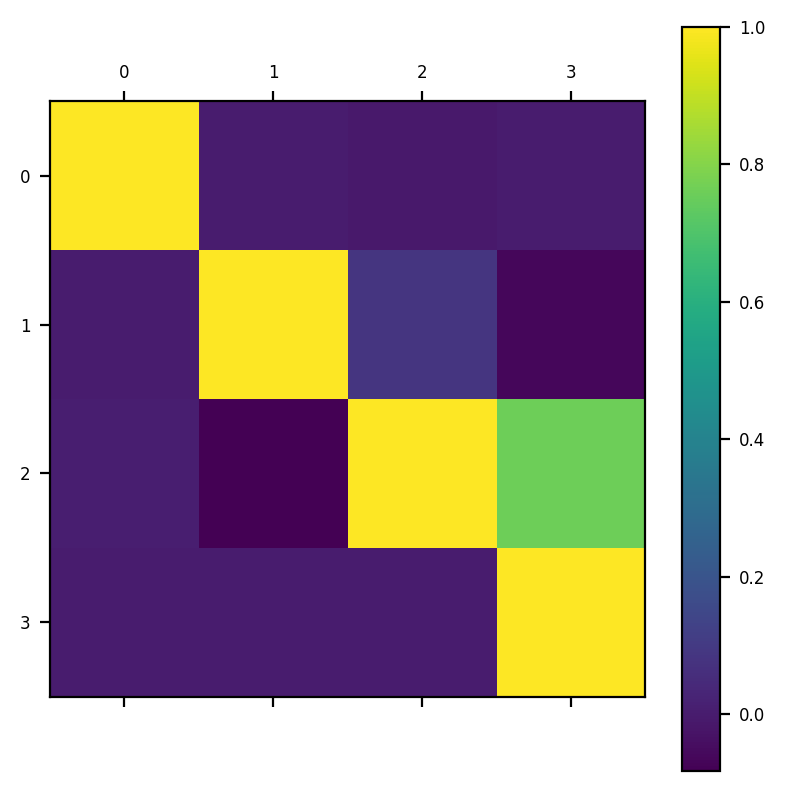

In [8]:
print(pose)

plt.matshow(pose)
plt.colorbar()
plt.show()

In [9]:
pose[:, 3]

array([ 2.52e-04, -6.26e-02,  7.62e-01,  1.00e+00])

## Convert pixel point to 3d point 

In [18]:
def convert_from_uvd(u, v, d, cam_matrix):
    """
        pxToMetre: Constant, depth scale factor
        cx: Center x of Camera
        cy: Center y of Camera
        focalx: Focal length
        focaly: Focal length 
    """

    pxToMetre = 1

    focalx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    focaly = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    d *= pxToMetre
    x_over_z = (cx - u) / focalx
    y_over_z = (cy - v) / focaly
    z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z

    return -y, x, z

def compute_xyz(depth_img, cam_matrix):

    # , fx, fy, px, py, height, width
    fx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    fy = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    height = 1000
    width = 1500

    indices = np.indices((height, width), dtype=np.float32).transpose(1, 2, 0)
    
    z_e = depth_img
    x_e = (indices[..., 1] - cx) * z_e / fx
    y_e = (indices[..., 0] - cy) * z_e / fy
    
    # Order of y_ e is reversed !
    xyz_img = np.stack([-y_e, x_e, z_e], axis=-1) # Shape: [H x W x 3]
    return xyz_img


In [19]:
center_point = [int(results[0].center[i]) for i in range(2)]
center_point

img_xyz = compute_xyz(img_real, cam_matrix)

# Ground Truth of AprilTag Center point
img_xyz[center_point[1]][center_point[0]]   # order of pixel array is y, x 

array([0.1 , 0.  , 1.22], dtype=float32)

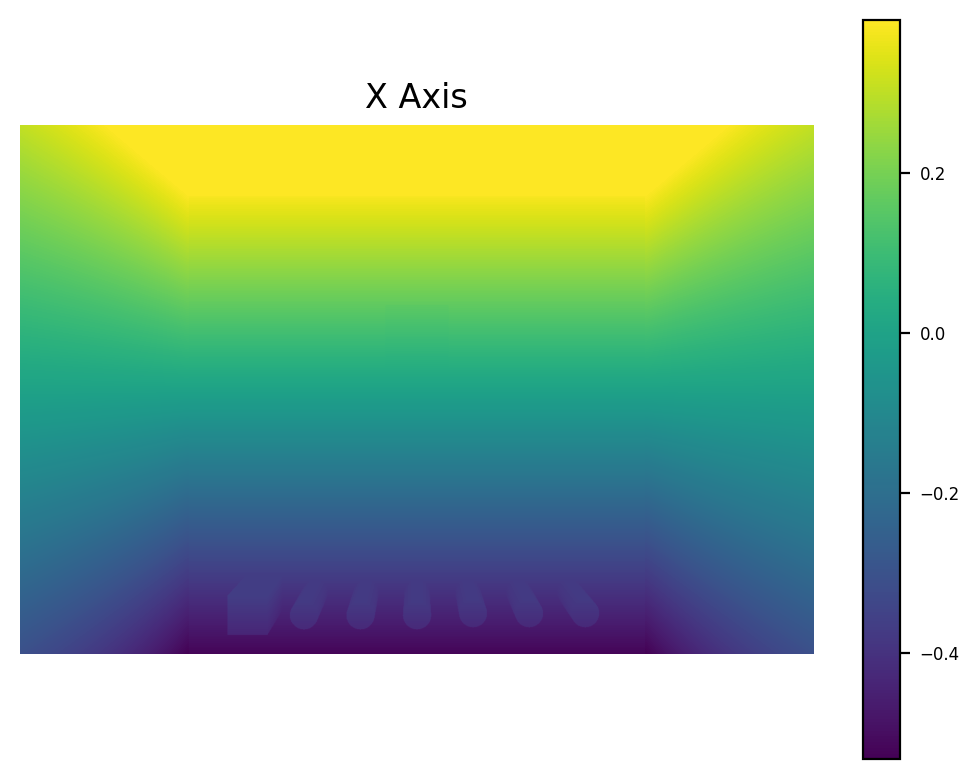

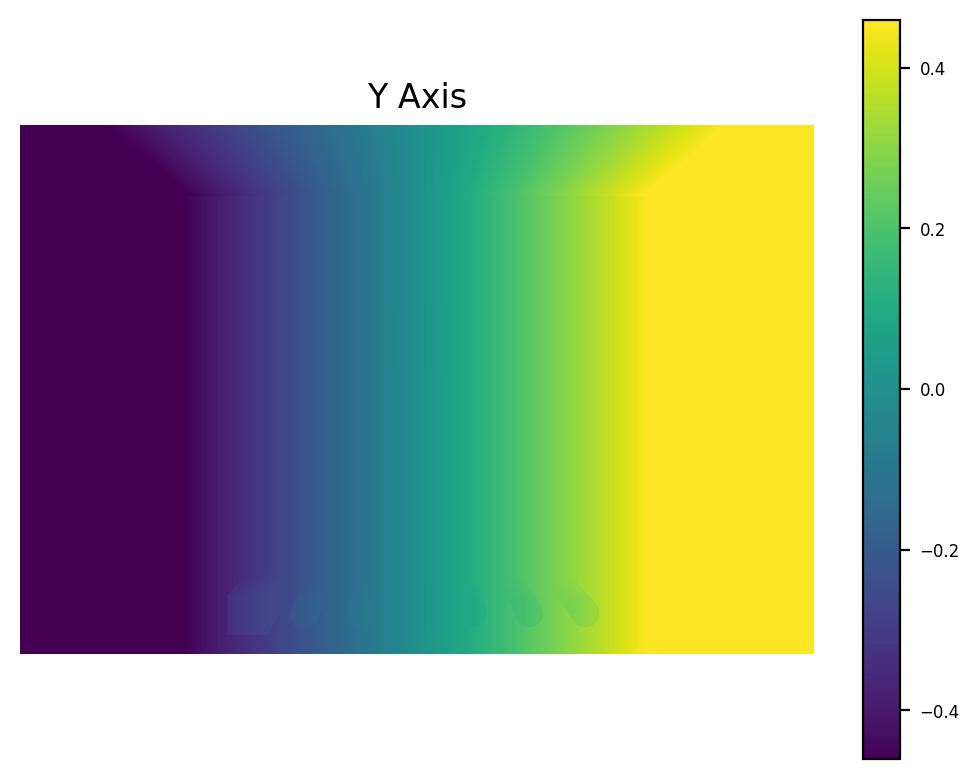

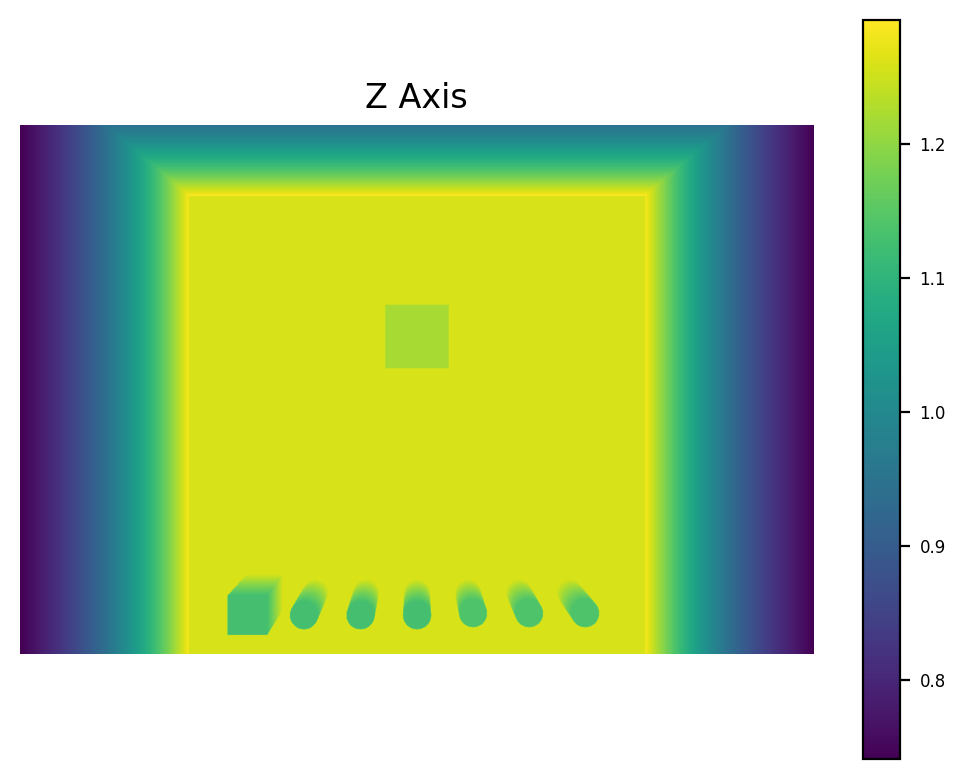

In [20]:
plt.imshow(img_xyz[:,:,0])  # X-axis
plt.title("X Axis")
plt.axis('off')
plt.colorbar()
plt.show()

plt.imshow(img_xyz[:,:,1])  # Y-axis
plt.title("Y Axis")
plt.axis('off')
plt.colorbar()
plt.show()

plt.imshow(img_xyz[:,:,2])  # Z-axis
plt.title("Z Axis")
plt.axis('off')
plt.colorbar()
plt.show()

#### Convert 2d pixel point to 3d point about corners

2D to 3D point function: `compute_xyz `

In [28]:
corner_points = []

# The orders of u, v are flipped !!
for i in range(4):
    corner_u = int(results[0].corners[i].ravel()[0])
    corner_v = int(results[0].corners[i].ravel()[1])
    corner_point = [corner_u, corner_v]

    corner_points.append(corner_point)

# 4 corner points at 3D local coordinate (camera).
corner_points = np.matrix(corner_points, dtype="int")
corner_points

matrix([[702, 353],
        [797, 353],
        [797, 447],
        [702, 447]])

In [30]:
img_3d = compute_xyz(img_real, cam_matrix)

for i in range(4):
    corner_3d_point = img_3d[corner_points[i, 1], corner_points[i, 0]]
    print(corner_3d_point)

center_point = [int(results[0].center[i]) for i in range(2)]

# Ground Truth of AprilTag Center point
print("Center 3D point")
print(img_3d[center_point[1], center_point[0], :])   # order of pixel array is y, x 

[ 0.15 -0.05  1.22]
[0.15 0.05 1.22]
[0.05 0.05 1.22]
[ 0.05 -0.05  1.22]
Center 3D point
[0.1  0.   1.22]


2D to 3D point function: `convert_from_uvd`

In [32]:
corner_3d_point = []

# The orders of u, v are flipped !!
for i in range(4):
    corner_u = results[0].corners[i].ravel()[0] # x axis
    corner_v = results[0].corners[i].ravel()[1] # y axis
    corner_u = int(corner_u)
    corner_v = int(corner_v)

    xyz = convert_from_uvd(corner_u, corner_v, img_real[corner_v, corner_u], cam_matrix)
    corner_3d_point.append(xyz)

# 4 corner points at 3D local coordinate (camera).
corner_3d_point = np.matrix(corner_3d_point, dtype="double")
corner_3d_point

matrix([[-0.15,  0.05,  1.21],
        [-0.15, -0.05,  1.21],
        [-0.05, -0.05,  1.22],
        [-0.05,  0.05,  1.22]])

In [34]:
center_3d_point = convert_from_uvd(center_point[0], center_point[1], img_real[center_point[1], center_point[0]], cam_matrix)
center_3d_point = np.matrix(center_3d_point, dtype="double")

center_3d_point

matrix([[-0.1 ,  0.  ,  1.22]])

In [35]:
trans_GT = cam_infos['cam_lookat'] - env.sim.data.get_body_xpos("box_checker")
trans_GT

array([-0.1 ,  0.  ,  0.73])

#### Get Camera `Intrinsic` informations

In [36]:
# Assume that there's no distortions.
distCoeffs = np.matrix([[0.0, 0.0, 0.0, 0.0, 0.0]])

# The camera has same fov value (=45).
cam_matrix, _, _ = env.camera_matrix_and_pose(width=env.render_height, height=env.render_width, camera_name="main1")

# cam_matrix[1][1] = -cam_matrix[1][1]
cam_matrix

array([[1.81e+03, 0.00e+00, 5.00e+02],
       [0.00e+00, 1.81e+03, 7.50e+02],
       [0.00e+00, 0.00e+00, 1.00e+00]])

#### Solve `Perspective-n-Points`

In [38]:
for i in range(len(corner_3d_point)):
    temp = corner_3d_point[i, 0]
    corner_3d_point[i, 0] = corner_3d_point[i, 1]
    corner_3d_point[i, 1] = temp

# convert (x,y,z) order
corner_3d_point

matrix([[ 0.05, -0.15,  1.21],
        [-0.05, -0.15,  1.21],
        [-0.05, -0.05,  1.22],
        [ 0.05, -0.05,  1.22]])

In [40]:
results[0].corners

array([[702.65, 353.99],
       [797.98, 353.99],
       [797.98, 447.99],
       [702.94, 447.99]])

In [41]:
corner_3d_point

matrix([[ 0.05, -0.15,  1.21],
        [-0.05, -0.15,  1.21],
        [-0.05, -0.05,  1.22],
        [ 0.05, -0.05,  1.22]])

In [43]:
ret, rotationVec, translationVec = cv2.solvePnP(corner_3d_point, results[0].corners, cam_matrix, distCoeffs)
 
# converting the rotation vector to a rotation matrix
rotation_mat, jacobian_mat = cv2.Rodrigues(rotationVec)
pose_mat = cv2.hconcat((rotation_mat, translationVec))

# Get euler angles
# _, _, _, _, _, _, euler_angles = cv2.decomposeProjectionMatrix(pose_mat)

pose_mat

array([[-1.00e+00,  1.20e-03,  9.31e-03,  2.40e-01],
       [ 2.01e-03,  9.96e-01,  8.75e-02, -3.56e-01],
       [-9.17e-03,  8.75e-02, -9.96e-01,  3.03e+00]])

In [44]:
# solving the perspective n point projection problem - using the iterative solver
(success, rotation_vector, translation_vector) = cv2.solvePnP(corner_3d_point, results[0].corners, cam_matrix, distCoeffs, flags=cv2.SOLVEPNP_ITERATIVE)

# converting the rotation vector to a rotation matrix
rot_mat, jacobian = cv2.Rodrigues(rotation_vector)

rot_mat

array([[-1.  ,  0.  ,  0.01],
       [ 0.  ,  1.  ,  0.09],
       [-0.01,  0.09, -1.  ]])

## Ground Truth of Extrinsic matrix

In [46]:
# env.sim.data.get_body_ximat("box_checker")
# apriltag_x, apriltag_y, apriltag_z = env.sim.data.get_body_xpos("box_checker")
# cam_x, cam_y, cam_z = cam_infos['cam_lookat']

# p_viewer = cam_infos['cam_lookat']
# R_viewer = rpy2r(np.deg2rad([0,-cam_infos['cam_elevation'],cam_infos['cam_azimuth']]))
# T_viewer = pr2t(p_viewer,R_viewer)
# T_viewer

trans_GT = cam_infos['cam_lookat'] - env.sim.data.get_body_xpos("box_checker")

trans_GT

array([-0.1 ,  0.  ,  0.73])

In [47]:
rot_GT = np.eye(3)
rot_GT

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [48]:
pose_mat

array([[-1.00e+00,  1.20e-03,  9.31e-03,  2.40e-01],
       [ 2.01e-03,  9.96e-01,  8.75e-02, -3.56e-01],
       [-9.17e-03,  8.75e-02, -9.96e-01,  3.03e+00]])

In [49]:
np.cross(np.linalg.inv(pose_mat[:3,:3]), pose_mat[:,3])

array([[ 2.85e-03,  3.03e+00,  3.56e-01],
       [ 3.05e+00,  1.74e-02, -2.40e-01],
       [-8.93e-02, -2.68e-01, -2.44e-02]])

## `Projection`: 3d Points to 2d pixel point

##### compare btw 3d point to 2d `reprojected` point and 2d original point

In [50]:
cubePoints = np.concatenate((corner_3d_point, np.concatenate((corner_3d_point[:,:2], corner_3d_point[:,2:] - 0.02), 1)))
computedImagePoints, j = cv2.projectPoints(cubePoints, rotationVec, translationVec, cam_matrix, distCoeffs)

print(computedImagePoints)
print(results[0].corners)

[[[702.9  353.98]]

 [[797.76 353.97]]

 [[798.16 447.98]]

 [[702.72 448.03]]

 [[700.51 356.55]]

 [[794.34 356.54]]

 [[794.74 449.53]]

 [[700.34 449.59]]]
[[702.65 353.99]
 [797.98 353.99]
 [797.98 447.99]
 [702.94 447.99]]


In [51]:
corner_int = np.array(results[0].corners, dtype='int')

## `TO-DO`: Get Multiple view of Cameras

In [52]:
cam_center = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.4,0.0,1.5])

cam_left = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = -30.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.4,0.3,1.5])

cam_right = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 30.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.4,-0.3,1.5])


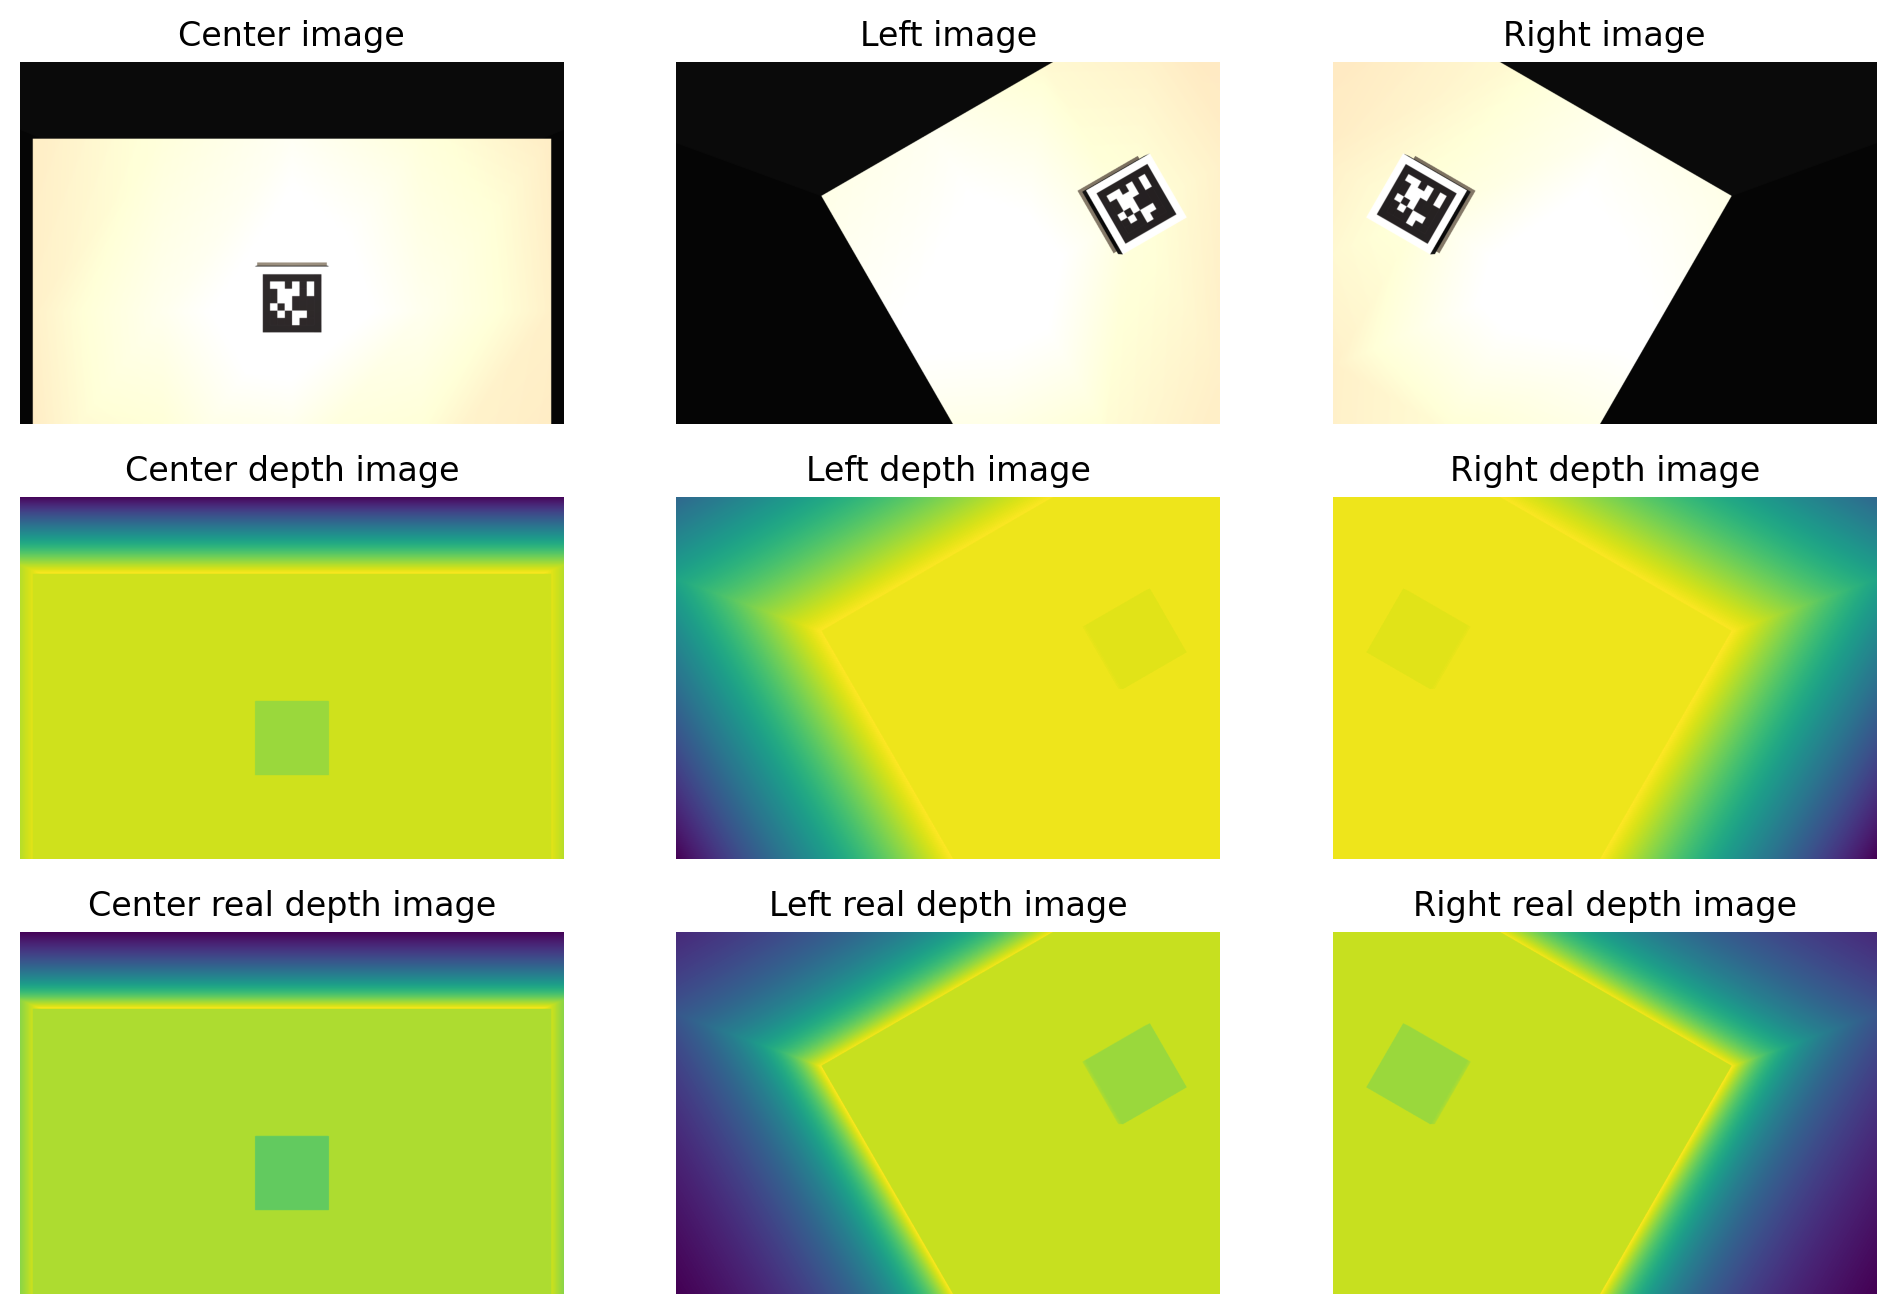

In [53]:
for _ in range(2):
    img_center = env.render_scene(mode='rgb_array', cam_infos=cam_center, width=width, height=height, depth_toggle=False, camera_name="track")
    img_center_depth = env.render_scene(mode='rgb_array', cam_infos=cam_center, width=width, height=height, depth_toggle=True, camera_name="track")
    img_center_real = np.array(env.depth2meters(img_center_depth))
for _ in range(2):
    img_left = env.render_scene(mode='rgb_array', cam_infos=cam_left, width=width, height=height, depth_toggle=False, camera_name="track")
    img_left_depth = env.render_scene(mode='rgb_array', cam_infos=cam_left, width=width, height=height, depth_toggle=True, camera_name="track")
    img_left_real = np.array(env.depth2meters(img_left_depth))
for _ in range(2):
    img_right = env.render_scene(mode='rgb_array', cam_infos=cam_right, width=width, height=height, depth_toggle=False, camera_name="track")
    img_right_depth = env.render_scene(mode='rgb_array', cam_infos=cam_right, width=width, height=height, depth_toggle=True, camera_name="track")
    img_right_real = np.array(env.depth2meters(img_right_depth))

plt.figure(figsize=(12, 8))
plt.subplot(3, 3, 1)
plt.imshow(img_center); plt.axis('off')
plt.title("Center image")
# plt.show()

plt.subplot(3, 3, 2)
plt.imshow(img_left); plt.axis('off')
plt.title("Left image")
# plt.show()

plt.subplot(3, 3, 3)
plt.imshow(img_right); plt.axis('off')
plt.title("Right image")
# plt.show()

# plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 4)
plt.imshow(img_center_depth); plt.axis('off')
plt.title("Center depth image")
# plt.show()

plt.subplot(3, 3, 5)
plt.imshow(img_left_depth); plt.axis('off')
plt.title("Left depth image")
# plt.show()

plt.subplot(3, 3, 6)
plt.imshow(img_right_depth); plt.axis('off')
plt.title("Right depth image")
# plt.show()

# plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 7)
plt.imshow(img_center_real); plt.axis('off')
plt.title("Center real depth image")
# plt.show()

plt.subplot(3, 3, 8)
plt.imshow(img_left_real); plt.axis('off')
plt.title("Left real depth image")
# plt.show()

plt.subplot(3, 3, 9)
plt.imshow(img_right_real); plt.axis('off')
plt.title("Right real depth image")
plt.show()


### Get AprilTag Corner points

In [54]:
import apriltag

imgs = [img_center, img_left, img_right]
results_list = []
pose_list = []

detector = apriltag.Detector()

for img in imgs:
    img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

    # detections, dimg = detector.detect(fram_gray, return_image=True)
    results = detector.detect(img_Gray)
    results_list.append(results)
    cam_matrix, _, _ = env.camera_matrix_and_pose(width=env.render_width, height=env.render_height, camera_name="main1")
    fx = cam_matrix[0][0]
    cx = cam_matrix[0][2]
    fy = cam_matrix[1][1]
    cy = cam_matrix[1][2]

    cam_params = [fx, fy, cx, cy]

    # Render the detections on the image
    if len(results) > 0:
        for r in results:
            pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.06)
            pose_list.append(pose)
            
            poseRotation = pose[:3, :3]
            poseTranslation = pose[:3, 3]


In [55]:
results_list[2]

[Detection(tag_family=b'tag36h11', tag_id=0, hamming=0, goodness=0.0, decision_margin=107.82823944091797, homography=array([[-6.16e-01,  3.52e-01, -2.03e+00],
        [-3.56e-01, -6.10e-01, -3.46e+00],
        [-1.94e-06, -5.00e-07, -8.78e-03]]), center=array([230.99, 393.83]), corners=array([[200.98, 283.88],
        [341.15, 364.87],
        [260.98, 503.72],
        [120.78, 422.79]]))]